<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/4.0-biGRU-1-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Layer biDirectional GRU using TensorFlow 2




In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
# add this to sys patch so we can import utility functions
DRIVE_DIR = 'drive/My Drive/Springboard/capstone'
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow 2.x selected.


'/device:GPU:0'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, GRU, \
                                    Dropout, Bidirectional, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import logging
import importlib
import json
import re

# custom utilities
import util.dict_util as du
import util.plot_util as pu
import util.keras_util as ku
import util.file_util as fu
import util.report_util as ru

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()



# check to see if we are using GPU - must be placed at the beginning of the program
tf.debugging.set_log_device_placement(True)
print("GPU Available: ", tf.test.is_gpu_available())
print(f'Tensorflow Version: {tf.version.VERSION}')
print(f'Keras Version: {tf.keras.__version__}')


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
FEATURE_COLUMN = "review_body"


DEBUG = False
MODEL_NAME = "GRU"
ARCHITECTURE = "1_bidirection_attention"
DESCRIPTION = "1 Layer Bi-directional GRU (250 units) attention"
FEATURE_SET_NAME = "random_embedding"


if DEBUG:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test1k-preprocessed.csv"
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-200k-preprocessed.csv"
  MODEL_NAME = f'test-{MODEL_NAME}'



RSTATE = 1
EMBED_SIZE = 300
EPOCHS  = 200
BATCH_SIZE = 128
GRU_DIM = 250 # total GRU units
# from our previous notebook, we saw that 90% of our reviews have 100 or less
MAX_SEQUENCE_LENGTH = 100
PATIENCE = 8



GPU Available:  True
Tensorflow Version: 2.0.0
Keras Version: 2.2.4-tf


In [0]:

df = pd.read_csv(DATA_FILE)





# Pre-process our data


In [4]:

X_train, X_test, y_train, y_test, tokenizer = \
                                  ku.preprocess_file(data_df=df, 
                                                      feature_column=FEATURE_COLUMN, 
                                                      label_column=LABEL_COLUMN, 
                                                      max_sequence_length = MAX_SEQUENCE_LENGTH)

One hot enocde label data...


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Vocabulary size=52524
Number of Documents=199134
Splitting data into training and test sets...


In [5]:
np.shape(X_train)

(149350, 100)

In [15]:
# Might have to play with this
vocab_size = len(tokenizer.word_counts)


# use functional syntax to create our graph
inp = layers.Input(shape=(MAX_SEQUENCE_LENGTH, ))
# since we are using OOV - we have to add 2 since there is an extra index plus
# we add 1 according to documentation
x = Embedding(vocab_size + 2, EMBED_SIZE, trainable=True)(inp)
x = Bidirectional(GRU(units=GRU_DIM, return_sequences=False))(x)
x = Dense(GRU_DIM*2, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(GRU_DIM, activation='relu')(x)
outp = Dense(5, activation='softmax')(x)

model = keras.models.Model(inputs=inp, outputs=outp)

model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(), 
              metrics=['categorical_accuracy'])

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0


In [16]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 300)          15757500  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 500)               828000    
_________________________________________________________________
dense_6 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 1255

In [17]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.4,
                              patience=PATIENCE, 
                              min_lr=0.00001,
                             mode='auto')

early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)


mw = ku.ModelWrapper(model, 
                     MODEL_NAME,
                     ARCHITECTURE,
                     FEATURE_SET_NAME,
                     LABEL_COLUMN,
                     DATA_FILE,
                     embed_size=EMBED_SIZE,
                     tokenizer=tokenizer,
                     description=DESCRIPTION)

history = mw.fit(X_train, 
                y_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                verbose=1,
                validation_split=0.2,
                callbacks=[early_stop, reduce_lr])

Number of training examples: 149350
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Train on 119480 samples, validate on 29870 samples
Epoch 1/200
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Exe

Number of test: 49784
Running model.evaluate...
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
49784/1 [===============================================================================================================================================================================================================================================================================================================================================================================

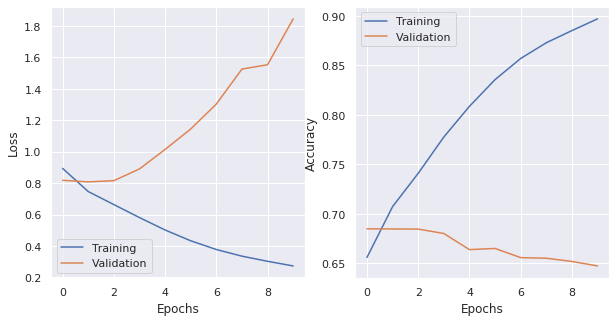


Confusion Matrix
[[ 5286   433   760   119   383]
 [ 1354   353   994   227   297]
 [  642   232  1839   961   866]
 [  177    52   974  2880  4215]
 [  297    27   504  2184 23728]]

Classification Report
              precision    recall  f1-score   support

           1       0.68      0.76      0.72      6981
           2       0.32      0.11      0.16      3225
           3       0.36      0.41      0.38      4540
           4       0.45      0.35      0.39      8298
           5       0.80      0.89      0.84     26740

    accuracy                           0.68     49784
   macro avg       0.52      0.50      0.50     49784
weighted avg       0.66      0.68      0.66     49784



drive/My Drive/Springboard/capstone/util/plot_util.py:252: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:252: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:256: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:256: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

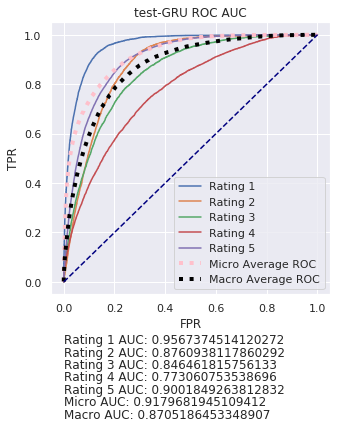

In [18]:
importlib.reload(pu)

scores = mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))



pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.roc_auc, mw.fpr, mw.tpr)



In [19]:
print(f'Score: {ru.calculate_metric(mw.crd)}')

Score: 0.293265245551101


# Save off files so we can load later

In [20]:
mw.save(DRIVE_DIR, append_report=False)


description: test-GRU-1_bidirection_attention-random_embedding-sampling_none-199134-100-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/test-GRU-1_bidirection_attention-random_embedding-sampling_none-199134-100-star_rating-model.h5
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Saving json config file: drive/My Drive/Springboard/capstone/models/test-GRU-1_bidirection_attention-random_embedding-sampling_none-199134-100-star_rating-model.json
Saving weights file: drive/My Drive/Springboard/capstone/models/test-GRU-1_bidirection_attention-random_embedding-sampling_none-199134-100-star_rating-weights.h5
Saving to report file: drive/My Drive/Springboard/capstone/reports/2019-11-dl_prototype-report.csv
{'model_name': 'test-GRU', 'architecture': '1_bidirection_attention', 'description': '1 Layer Bi-directional GRU (250 units) attention', 'classification_report': '{"1": {"precision": 0.6815368746776689, "recall": 0.7571981091534165,

In [23]:
from datetime import datetime
print(datetime.now())

2019-11-07 06:46:09.149827


# Loading the models

We are going to load the models and re-create our networks in a couple different ways

After that, we are going to run the same prediction as before. Results should be

```
array([4, 3, 4, 2, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 3, 4, 0, 4, 4, 3])
```

## First - let's load the model with weights and then run the same predictions as before to see if we get she same values

In [0]:
# model_loaded = keras.models.load_model(MODEL_FILE, custom_objects={'AttentionLayer': AttentionLayer})

In [0]:
# np.argmax(model_loaded.predict(X_test[:20]), axis=1)

## Second - let's load it using our json config and weights

we will run the same tests as before and see how this looks

In [0]:
# import json

# with open(MODEL_JSON_FILE) as json_file:
#   json_config = json_file.read()
# model_from_json = keras.models.model_from_json(json_config, custom_objects={'AttentionLayer': AttentionLayer})
# model_from_json.load_weights(WEIGHTS_FILE)

In [0]:
# np.argmax(model_from_json.predict(X_test[:20]), axis=1)